In [1]:
CODE_PATH = "../trainer"

In [2]:
import sys
sys.path.append(CODE_PATH)

In [3]:
import os

import torch
import torchvision as tv
from transformers import AutoTokenizer

from ignite.engine import (
    Engine,
    Events,
)
from ignite.handlers import Checkpoint
from ignite.contrib.handlers import global_step_from_engine
from ignite.contrib.handlers import ProgressBar
from ignite.contrib.handlers.neptune_logger import NeptuneLogger

/home/israel/Mestrado/mscenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from datamodule import IIIT5KDataModule
from model import  OCRModel, AbstractCNN
from ctc import GreedyDecoder
from igmetrics import ExactMatch, WordF1, CER

In [5]:
tokenizer = AutoTokenizer.from_pretrained(f"{CODE_PATH}/iiit5k-tokenizers/tokenizer-pad0")
decoder = GreedyDecoder(tokenizer.pad_token_id)

In [6]:
tokenizer.eos_token_id, tokenizer.pad_token_id, tokenizer.vocab_size

(1, 0, 42)

In [7]:
if tokenizer.eos_token_id is None:
    tokenizer.eos_token = tokenizer.sep_token
    tokenizer.eos_token_id = tokenizer.sep_token_id

In [8]:
tokenizer.eos_token, tokenizer.eos_token_id

('</s>', 1)

# Loader

In [9]:
DATA_PATH = "../data/IIIT5K/IIIT5K/"
POOLER_MODE = "mine" 

In [10]:
# !unzip {DATA_PATH}/data.zip

In [11]:
dm = IIIT5KDataModule(
    root_dir="../data/IIIT5K/IIIT5K/",
    label_file=os.path.join(DATA_PATH, "train.json"),
    tokenizer=tokenizer,
    height=32,
    num_workers=4,
    train_bs=4,
    valid_bs=4,
    val_pct=0.1,
    max_width=None,
    do_pool=True,
    pooler_mode=POOLER_MODE
)

In [12]:
dm.setup("fit")

# Model

In [13]:
from torch import nn

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)
    
class Feature2Embedding(nn.Module):
    def forward(self, x):
        n, c, h, w = x.shape
        assert h == 1, "the height of out must be 1"
        x = x.squeeze(2) # [n, c, w]
        return x.permute(0, 2, 1)#.reshape(n, -1, c)

class CNNSmallDropout(nn.Module):
    """
    Custom CNN
    """

    def __init__(
        self,
        vocab_size: int = 100,
        p: float = 0.15,
    ):
        super().__init__()

        self.image_embeddings = nn.Sequential(
            self.block(3, 64, st=(2, 2)),
            nn.Dropout2d(p),
            self.block(64, 128, st=(2, 2)),
            nn.Dropout2d(p),
            self.block(128, 256, st=(2, 1)),
            nn.Dropout2d(p),
            self.block(256, 512, st=(4, 1)),
            nn.Dropout2d(p),
            Feature2Embedding(),
        )
        self.lm_head = nn.Linear(512, vocab_size)

    def block(self, in_channels, out_channels, st=2):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            Swish(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=st, padding=1),
            nn.BatchNorm2d(out_channels),
            Swish(),
        )

    def forward(self, images, *args, **kwargs):
        embedding = self.image_embeddings(images)
        return embedding

    def lm(self, embedding):
        return self.lm_head(embedding)

In [14]:
from transformers import DebertaV2ForTokenClassification, DebertaV2Config

class AbstractTransformersEncoder(torch.nn.Module):
    def __init__(self, vocab_size: int = 100, config_dict: dict = {}):
        super().__init__()
        self.vocab_size = vocab_size
        config_dict = self._get_config_dict(config_dict)
        config = DebertaV2Config(**config_dict)
        self.encoder = DebertaV2ForTokenClassification(config)

    def _get_config_dict(self, config_dict):
        base_config_dict = {
            "model_type": "deberta-v2",
            "architectures": ["DebertaV2ForTokenClassification"],
            "num_labels": self.vocab_size,
            "model_type": "deberta-v2",
            "attention_probs_dropout_prob": 0.15,
            "hidden_act": "gelu",
            "hidden_dropout_prob": 0.15,
            "hidden_size": 512,
            "initializer_range": 0.02,
            "intermediate_size": 768,  # 3072,
            "max_position_embeddings": 512,
            "relative_attention": True,
            "position_buckets": 64,  # TODO: Maybe less?
            "norm_rel_ebd": "layer_norm",
            "share_att_key": True,
            "pos_att_type": "p2c|c2p",
            "layer_norm_eps": 1e-7,
            "max_relative_positions": -1,
            "position_biased_input": True,
            "num_attention_heads": 8,
            "num_hidden_layers": 3,
            "type_vocab_size": 0,
            "pad_token_id": tokenizer.pad_token_id,
            "eos_token_id": tokenizer.eos_token_id,
            "vocab_size": self.vocab_size,
        }
        base_config_dict.update(config_dict)
        return base_config_dict

    def forward(self, image_embeddings, attention_mask=None):
        outputs = self.encoder(
            inputs_embeds=image_embeddings, attention_mask=attention_mask
        )
        return outputs.logits

In [15]:
vis_model = CNNSmallDropout(vocab_size=tokenizer.vocab_size, p=0.15)
rec_model = AbstractTransformersEncoder(vocab_size=tokenizer.vocab_size)
model = OCRModel(vis_model, rec_model)

In [16]:
_ = model.to("cpu")

In [17]:
batch = next(iter(dm.train_dataloader()))
with torch.no_grad():
    images, labels, attention_mask, attention_image = batch
    logits = model(images, attention_image)
logits.shape

torch.Size([4, 42, 42])

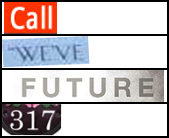

In [18]:
# display images using torchvision utils make_grid
grid = tv.utils.make_grid(images, nrow=1)
tv.transforms.ToPILImage()(grid)

In [19]:
attention_mask.sum(-1), attention_image.sum(-1)

(tensor([5, 5, 7, 4]), tensor([15, 23, 42, 16]))

In [20]:
labels

tensor([[25,  7, 31, 31,  1,  0,  0],
        [16, 29, 32, 29,  1,  0,  0],
        [ 6, 22, 18, 22, 34, 29,  1],
        [41, 17, 38,  1,  0,  0,  0]])

In [21]:
tokenizer.batch_decode(labels, skip_special_tokens=False)

['CALL</s><pad><pad>',
 'WEVE</s><pad><pad>',
 'FUTURE</s>',
 '317</s><pad><pad><pad>']

In [22]:
logits.argmax(-1)

tensor([[30,  4, 16, 36, 15,  9, 19, 18,  1, 34, 23, 23, 34,  7,  3,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0],
        [24, 14, 32, 14, 13, 41,  1, 39, 31, 37, 40, 39, 24, 13,  5,  4,  1, 24,
          5, 24,  0,  7, 39,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0],
        [19, 20,  1, 10, 40, 27, 10,  1, 41,  1, 39, 31, 34, 27,  5, 40,  1, 30,
         27, 30, 41, 32, 39, 10, 21, 39, 31, 32, 12, 31,  3, 39, 39, 30, 39,  6,
         29, 39, 30,  6, 39, 31],
        [12, 29, 29, 14, 10, 32, 17,  4, 14, 26, 37, 37, 37, 19, 18, 22,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0]])

# Ignite

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [37]:
_ = model.to(device)

In [38]:
val_loader = dm.val_dataloader()
train_loader = dm.train_dataloader()

In [39]:
MAX_EPOCHS=600
STEPS = len(train_loader) * MAX_EPOCHS
STEPS

30000

In [40]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, STEPS, 1e-6)
criterion = torch.nn.CTCLoss(blank=tokenizer.pad_token_id, zero_infinity=True)

In [41]:
def get_preds_from_logits(logits, attention_image, labels):
    decoded_ids = logits.argmax(-1).squeeze(0)
    if len(decoded_ids.shape) == 1:
        decoded_ids = decoded_ids.unsqueeze(0)
    
    if attention_image is None:
        attention_image = len(decoded_ids) * [None]

    decoded = [
        decoder(dec, att) for dec, att in zip(decoded_ids, attention_image)
    ]
    y_pred = tokenizer.batch_decode(decoded, skip_special_tokens=True)
    y = tokenizer.batch_decode(labels, skip_special_tokens=True)
    return y_pred, y

In [42]:
def train_step(engine, batch):
    model.train()
    optimizer.zero_grad()

    images, labels, attention_mask, attention_image = [x.to(device) if x is not None else x for x in batch]

    images_embedding = model.visual_model(images)
    logits = model.rec_model(images_embedding, attention_mask=attention_image)

    if attention_image is not None:
        input_length = attention_image.sum(-1)
    else:
        input_length = torch.full(
            size=(logits.size(0),),
            fill_value=logits.size(1),
            dtype=torch.int32,
        )

    target_length = attention_mask.sum(-1)

    logits = logits.permute(1, 0, 2)
    logits = logits.log_softmax(2)

    loss = criterion(logits, labels, input_length, target_length)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()
    lr_scheduler.step()
    return loss.item()

In [43]:
def val_step(engine, batch):
    model.eval()
    images, labels, attention_mask, attention_image = [x.to(device) if x is not None else x for x in batch]
    with torch.no_grad():
        logits = model(images, attention_image)

    y_pred, y = get_preds_from_logits(logits, attention_image, labels)
    return y_pred, y
    

In [44]:
trainer = Engine(train_step)
train_evaluator = Engine(val_step)
validation_evaluator = Engine(val_step)

In [45]:
def log_validation_results(engine):
    validation_evaluator.run(val_loader)
    metrics = validation_evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    print(f"Validation Results - Epoch: {engine.state.epoch}  Avg accuracy: {avg_accuracy:.3f}")

def log_train_results(engine):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    print(f"Validation Results - Epoch: {engine.state.epoch}  Avg accuracy: {avg_accuracy:.3f}")

In [46]:
ExactMatch().attach(validation_evaluator, "accuracy")
ExactMatch().attach(train_evaluator, "accuracy")

trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_train_results)

In [47]:
to_save = {'model': model}
handler = Checkpoint(
    to_save, 
    "iiit5k-checkpoint-models",
    n_saved=1, 
    filename_prefix='best',
    score_name="accuracy",
    global_step_transform=global_step_from_engine(trainer)
)
validation_evaluator.add_event_handler(Events.COMPLETED, handler)

In [85]:
neptune_logger = NeptuneLogger(
    project="i155825/SVT",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhOGUyY2VlOS1hZTU5LTQ2NGQtYTY5Zi04OGJmZWM2M2NlMDAifQ==",
)

neptune_logger.attach_output_handler(
    trainer,
    event_name=Events.ITERATION_COMPLETED,
    tag="training",
    output_transform=lambda loss: {"loss": loss},
)

neptune_logger.attach_output_handler(
    validation_evaluator,
    event_name=Events.EPOCH_COMPLETED,
    tag="validation",
    metric_names=["accuracy"],
    global_step_transform=global_step_from_engine(trainer),  
)

neptune_logger.attach_output_handler(
    train_evaluator,
    event_name=Events.EPOCH_COMPLETED,
    tag="training",
    metric_names=["accuracy"],
    global_step_transform=global_step_from_engine(trainer),  
)

neptune_logger["code"].upload_files([
    f"{CODE_PATH}/*.py", 
    f"{CODE_PATH}/**/*.py",
    __file__
])

https://app.neptune.ai/i155825/SVT/e/SVT-2


NameError: name 'train_evaluator' is not defined

In [48]:
pbar = ProgressBar()
pbar.attach(trainer, output_transform=lambda x: {'loss': x})

In [49]:
trainer.run(train_loader, max_epochs=MAX_EPOCHS)

Epoch [1/600]: [49/50]  98%|█████████▊, loss=2.63 [00:02<00:00]

Validation Results - Epoch: 1  Avg accuracy: 0.000


Validation Results - Epoch: 1  Avg accuracy: 0.000


Epoch [2/600]: [50/50] 100%|██████████, loss=2.43 [00:03<00:00]

Validation Results - Epoch: 2  Avg accuracy: 0.000


Validation Results - Epoch: 2  Avg accuracy: 0.000


Epoch [3/600]: [49/50]  98%|█████████▊, loss=2.16 [00:02<00:00]

Validation Results - Epoch: 3  Avg accuracy: 0.000


Validation Results - Epoch: 3  Avg accuracy: 0.000


Epoch [4/600]: [49/50]  98%|█████████▊, loss=2.07 [00:02<00:00]

Validation Results - Epoch: 4  Avg accuracy: 0.005


Validation Results - Epoch: 4  Avg accuracy: 0.005


Epoch [5/600]: [49/50]  98%|█████████▊, loss=1.64 [00:02<00:00]

Validation Results - Epoch: 5  Avg accuracy: 0.025


Validation Results - Epoch: 5  Avg accuracy: 0.025


Epoch [6/600]: [50/50] 100%|██████████, loss=1.28 [00:02<00:00]

Validation Results - Epoch: 6  Avg accuracy: 0.065


Validation Results - Epoch: 6  Avg accuracy: 0.065


Epoch [7/600]: [50/50] 100%|██████████, loss=0.981 [00:02<00:00]

Validation Results - Epoch: 7  Avg accuracy: 0.085


Validation Results - Epoch: 7  Avg accuracy: 0.085


Epoch [8/600]: [50/50] 100%|██████████, loss=0.723 [00:02<00:00]

Validation Results - Epoch: 8  Avg accuracy: 0.150


Validation Results - Epoch: 8  Avg accuracy: 0.150


Epoch [9/600]: [49/50]  98%|█████████▊, loss=0.607 [00:03<00:00]

Validation Results - Epoch: 9  Avg accuracy: 0.170


Validation Results - Epoch: 9  Avg accuracy: 0.170


Epoch [10/600]: [49/50]  98%|█████████▊, loss=0.387 [00:02<00:00]

Validation Results - Epoch: 10  Avg accuracy: 0.210


Validation Results - Epoch: 10  Avg accuracy: 0.210


Epoch [11/600]: [11/50]  22%|██▏       , loss=0.404 [00:00<00:02]Engine run is terminating due to exception: 


In [46]:
batch = next(iter(dm.val_dataloader()))

In [47]:
y_pred, y = val_step(None, batch)

In [48]:
y_pred, y

(['SHAEOAP', 'SOAE', 'SOM', 'HEUEN'], ['SING', 'YANK', 'BIERSCH', 'BREWERY'])

Epoch [4/100]: [8/54]  15%|█▍        , loss=0.0328 [00:19<00:02]